In [2]:
from models.q_network import CardFeaturizer1, CardFeaturizer2, CardFeaturizer3
import torch as t
from game.utils import variable
import numpy as np
from game.game_utils import Card, cards_to_array
from matplotlib import pyplot as plt
from sklearn.utils import shuffle
from IPython import display

# Load dataset

In [4]:
import pickle
filenames = ['hand_eval_2.p',
             'hand_eval_51511068091.1125414.p',
             'hand_eval_51511071691.158362.p',
             'hand_eval_51511075291.2004554.p',
             'hand_eval_51511078891.2243085.p',
             'hand_eval_51511082491.277018.p',
             'hand_eval_51511086091.2965872.p',
             'hand_eval_51511093291.367359.p',
             'hand_eval_51511100491.4335415.p',
             'hand_eval_51511104091.4605765.p',
             'hand_eval_51511107691.4960084.p']

for filename in filenames:
    with open(filename, 'rb') as f:
        dataset_ = pickle.load(f)
        try:
            for k,v in dataset_.items():
                train_dataset[k] = v
        except:
            train_dataset = dataset_

In [5]:
import pickle
filenames = ['hand_eval_51511089691.300083.p']
for filename in filenames:
    with open(filename, 'rb') as f:
        dataset_ = pickle.load(f)
        try:
            for k,v in dataset_.items():
                test_dataset[k] = v
        except:
            test_dataset = dataset_


In [6]:
len(train_dataset), len(test_dataset)

(669599, 54652)

# Parse dataset

frozenset({'2d', '6c', '9d', '7s'})): {'player1winprob': 0.15217391304347827, 'High Card': 0.5217391304347826, 'Pair': 0.391304347826087, 'Two Pair': 0.0, 'Three of a Kind': 0.0, 'Straight': 0.08695652173913043, 'Flush': 0.0, 'Full House': 0.0, 'Four of a Kind': 0.0, 'Straight Flush': 0.0, 'Royal Flush': 0.0}}
Time diff is 0.002004861831665039

In [8]:
def clip(x):
    return x*(x>=1e-2)*(x<=.99) + .99*(x>.99) + .01*(x<.01)

In [9]:
def parse_dataset(dataset):
    x_hand = np.zeros((len(dataset), 13, 4))
    x_board = np.zeros((len(dataset), 3, 13, 4))
    y = np.zeros((len(dataset),))

    for i, (cards_, probas) in enumerate(dataset.items()):
        # if there are only two cards and nothing on the board then the keys don't have the same format.....
        if isinstance(cards_, tuple):
            hand_, board_ = cards_
        else:
            hand_ = cards_
            board_ = None

        hand = []
        board = []

        for card_ in hand_:
            if card_[0] != 'T':
                try:
                    hand.append(Card(card_[0], card_[1]))
                except:
                    print(hand_, board_)
                    raise Exception
            else:
                hand.append(Card('10', card_[1]))

        if board_ is not None:
            for card_ in board_:
                if card_[0] != 'T':
                    board.append(Card(card_[0], card_[1]))
                else:
                    board.append(Card('10', card_[1]))

        x_hand[i] = cards_to_array(hand)
        x_board[i] = cards_to_array(board)
        hs = clip(probas['player1winprob'])
        y[i] = np.log(hs/(1-hs))
#         y[i][0] = probas['player1winprob']
#         y[i][1] = probas['High Card']
#         y[i][2] = probas['Pair']
#         y[i][3] = probas['Two Pair']
#         y[i][4] = probas['Three of a Kind']
#         y[i][5] = probas['Straight']
#         y[i][6] = probas['Flush']
#         y[i][7] = probas['Full House']
#         y[i][8] = probas['Four of a Kind']
#         y[i][9] = probas['Straight Flush']
    return x_hand, x_board, y


In [10]:
x_hand_train, x_board_train, y_train = parse_dataset(train_dataset)
x_hand_test, x_board_test, y_test = parse_dataset(test_dataset)

In [11]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
y_train = scaler.fit_transform(y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:586: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


In [12]:
y_test = scaler.transform(y_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


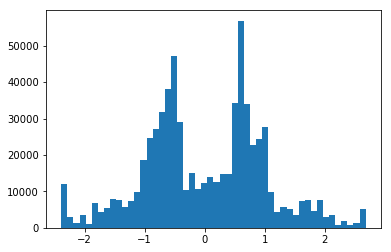

In [13]:
plt.hist(y_train, bins=50)
plt.show()

# Train neural network

In [55]:
f = CardFeaturizer1(20)
print('#params: ', np.sum([np.prod(p.data.numpy().shape) for p in f.parameters()]))

#params:  12089


In [56]:
# initialization of weights for using selu activation

for i in range(1, 19):
    if i == 16 or i == 17:
        continue
    fcc = getattr(f, 'fc'+str(i))
    shape = fcc.weight.data.numpy().shape
    fcc.weight.data = t.from_numpy(np.random.normal(0, 1/np.sqrt(shape[0]), shape)).float()

for i in range(1, 6):
    convv = getattr(f, 'conv'+str(i))
    shape = convv.weight.data.numpy().shape
    convv.weight.data = t.from_numpy(np.random.normal(0, 1/np.sqrt(shape[-1]*shape[-2]), shape)).float()


In [57]:
def clip(x):
    return x*(x>=1e-2).float()*(x<=.99).float() + .99*(x>.99).float() + .01*(x<.01).float()

epoch 0


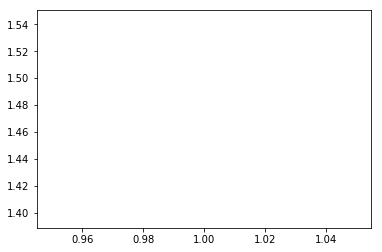

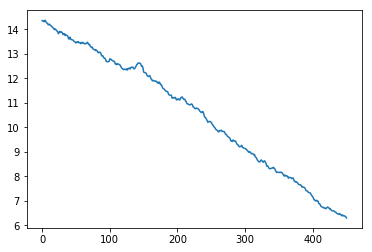

In [ ]:
lr = 1e-4  # 1e-4 for selu
batch_size = 64
EPOCHS = 50
optimizer = t.optim.Adam(f.parameters(), lr=lr, weight_decay=1e-3)
train_losses = []
test_losses = []
PLOT = 500


for _ in range(EPOCHS):
    print('epoch', _)
    
    # shuffle
    x_hand_train, x_board_train, y_train = shuffle(x_hand_train, x_board_train, y_train)
    
    # check if weights are NaN
    for p in f.parameters():
        if np.isnan(p.data.numpy()).sum()>0:
            raise ValueError('nan weights !')
    
    for i in range(0, len(train_dataset), batch_size):
        # check if BN var is NaN
#         check_bn_var_nan(f)
        
        # sample batch
        hand = variable(x_hand_train[i:i+batch_size])
        board = variable(x_board_train[i:i+batch_size])
        target = variable(y_train[i:i+batch_size]).squeeze()
        if len(hand) != batch_size:
            break
        
        # init grad
        optimizer.zero_grad()
        
        # pred
        HS = clip(f.forward(hand, board).squeeze())
        pred = t.log(HS/(1-HS))
        loss = (target - pred)**2  # target already has this format (scaled logit)
        loss = t.sum(loss)
        train_losses.append(loss.data.numpy()[0]/batch_size)
        
        loss.backward()
#         clip_gradients(f, 5)
        
        optimizer.step()
        
        if (i//batch_size) % PLOT == 0:
            display.clear_output(wait=True)
            print('epoch', _)
            
            # test loss on a random test sample
            x_hand_test, x_board_test, y_test = shuffle(x_hand_test, x_board_test, y_test)
            hand = variable(x_hand_test[:1000])
            board = variable(x_board_test[:1000])
            target = variable(y_test[:1000]).squeeze()
            f.eval()
            HS = f.forward(hand, board).squeeze() + 1e-5
            f.train()
            pred = t.log(HS/(1-HS))
            loss = (target - pred)**2
            loss = t.sum(loss)      
            test_losses.append(loss.data.numpy()[0]/1000)
            
            # plot
            plt.plot(test_losses)
            plt.show()
            plt.plot(moving_avg(train_losses))
            plt.show()

Test of the model

In [685]:
IDX_TO_RANK = {k:v for k,v in enumerate(Card.RANKS)}
IDX_TO_SUIT = {k:v for k,v in enumerate(Card.SUITS)}

def array_to_card(array):
    if isinstance(array, t.autograd.Variable):
        array_ = array.data.numpy()
    else:
        array_ = array
    cards = []
    for i in range(13):
        for j in range(4):
            if array_[i][j] == 1:
                cards.append(Card(IDX_TO_RANK[i], IDX_TO_SUIT[j]))
    return cards


In [686]:
def c(r, s):
    return Card(r, s)

Test with very small variations

In [688]:
f.eval()

CardFeaturizer (
  (conv1): Conv1d(2, 5, kernel_size=(1,), stride=(1,))
  (conv1_bn): BatchNorm1d(5, eps=1e-05, momentum=0.1, affine=True)
  (conv2): Conv1d(5, 1, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv2_bn): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True)
  (conv3): Conv1d(5, 1, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv3_bn): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True)
  (conv4): Conv1d(5, 3, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,))
  (conv4_bn): BatchNorm1d(3, eps=1e-05, momentum=0.1, affine=True)
  (conv5): Conv1d(2, 1, kernel_size=(1,), stride=(1,))
  (conv5_bn): BatchNorm1d(1, eps=1e-05, momentum=0.1, affine=True)
  (fc1): Linear (65 -> 20)
  (fc1_bn): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True)
  (fc2): Linear (26 -> 20)
  (fc2_bn): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True)
  (fc3): Linear (20 -> 20)
  (fc3_bn): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True)
  (fc4): Linear (4 -> 20)
  (fc4_bn):

In [693]:
np.sum(np.isnan(f.fc10_bn.running_var.numpy()))

20

In [689]:
hand = variable(cards_to_array([c('Q','s'), c('K', 'h')])).resize(1,13,4)
board1 = variable(cards_to_array([c('2','c'),c('5','h'),c('Q','h')])).resize(1,3,13,4)
board2 = variable(cards_to_array([c('3','c'),c('5','h'),c('Q','h')])).resize(1,3,13,4)
board3 = variable(cards_to_array([c('4','c'),c('5','h'),c('Q','h')])).resize(1,3,13,4)
board4 = variable(cards_to_array([c('2','s'),c('7','h'),c('Q','h')])).resize(1,3,13,4)
board5 = variable(cards_to_array([c('2','c'),c('6','h'),c('Q','h')])).resize(1,3,13,4)
board6 = variable(cards_to_array([c('2','c'),c('5','h'),c('Q','h')])).resize(1,3,13,4)
board7 = variable(cards_to_array([c('2','d'),c('3','h'),c('Q','h')])).resize(1,3,13,4)
print(f(hand,board1).data.numpy()[0], f(hand,board2).data.numpy()[0], f(hand,board3).data.numpy()[0], f(hand,board4).data.numpy()[0], f(hand,board5).data.numpy()[0], f(hand,board6).data.numpy()[0], f(hand,board7).data.numpy()[0])

[ nan] [ nan] [ nan] [ nan] [ nan] [ nan] [ nan]


In [548]:
t.sum((f(hand,board1,True)[1] - f(hand,board3,True)[1])**2)

Variable containing:
 0
[torch.FloatTensor of size 1]

In [556]:
hand1 = variable(cards_to_array([c('Q','s'), c('Q', 'h')])).resize(1,13,4)
board1 = variable(cards_to_array([c('2','c'),c('5','h'),c('Q','c')])).resize(1,3,13,4)

hand2 = variable(cards_to_array([c('10','s'), c('10', 'h')])).resize(1,13,4)
board2 = variable(cards_to_array([c('A','s'),c('8','h'),c('A','c')])).resize(1,3,13,4)


In [557]:
t.sum((f(hand1,board1,True)[1] - f(hand2,board2,True)[1])**2)

Variable containing:
 0
[torch.FloatTensor of size 1]

In [584]:
hand1 = variable(cards_to_array([c('Q','c'), c('4', 'c')])).resize(1,13,4)
board1 = variable(cards_to_array([c('5','h'),c('9','c'),c('10','h')])).resize(1,3,13,4)

hand2 = variable(cards_to_array([c('Q','c'), c('9', 'c')])).resize(1,13,4)
board2 = variable(cards_to_array([c('6','d'),c('A','s'),c('A','d')])).resize(1,3,13,4)

f(hand2,board2,True)[0].data.numpy()

array([[ 0.37721184]], dtype=float32)

Look at some predictions

In [585]:
hand = variable(x_hand_train[i:i+batch_size])
board = variable(x_board_train[i:i+batch_size])
target = clip(variable(y_train[i:i+batch_size, 0])).squeeze()

In [586]:
pred = f.forward(hand,board).squeeze()
for i in range(64):
    print(array_to_card(hand[i]), array_to_card(t.sum(board[i],0)), target[i].data.numpy()[0], pred[i].data.numpy()[0])

[Ks, Kd] [2s, 2d, 9d] 0.961147 0.652173
[3c, 9h] [6h, 7h, 9d] 0.673451 0.528163
[3h, 8c] [3d, 9h, Ad] 0.779833 0.520679
[3d, 10s] [5d, 10h, Jc] 0.170213 0.562264
[7d, Kd] [3s, 4s, 6s] 0.707678 0.310451
[7c, Js] [6c, 9c, Jh] 0.855689 0.698572
[7c, Ah] [9s, 10s, Kd] 0.126735 0.331615
[2d, 5h] [3c, 7h, Qs] 0.0175763 0.141836
[6h, 10c] [4s, 8c, 9s] 0.182239 0.222856
[4s, 6s] [3c, 7c, Kh] 0.3395 0.170632
[3c, 9s] [7s, 10d, Ad] 0.237743 0.137893
[4d, 8c] [2d, Js, Ac] 0.113784 0.112954
[7d, 8d] [5c, Qs, As] 0.224792 0.144312
[6h, 6s] [2s, 7h, 8h] 0.707678 0.549673
[8s, Kc] [8c, 10c, Js] 0.259019 0.567396
[4h, Kh] [7d, Jh, Ac] 0.154487 0.277426
[5s, 6s] [5c, Kd, As] 0.666975 0.520631
[5h, Qc] [3d, 6h, 8h] 0.273821 0.265489
[3d, Jd] [5c, 9h, Js] 0.741906 0.607145
[2s, Ad] [9h, 10s, Ac] 0.979648 0.628375
[5h, 7c] [2d, 4s, 5d] 0.759482 0.562875
[3d, 9c] [3s, 6c, Qd] 0.692877 0.500466
[3h, 10c] [4h, Qh, Ah] 0.344126 0.25113
[2h, 7s] [2d, 9d, Qc] 0.665125 0.516606
[3h, Kc] [5h, 7c, 7s] 0.66235 0.20

In [593]:
f.forward(hand,board,True)[1]

Variable containing:
-1.3941e-01 -2.5870e-03 -6.1545e-11  ...  -5.6580e-01  6.7116e-02 -9.8039e-03
-1.3361e-01 -3.1099e-03 -1.2130e-10  ...  -2.5143e-01  2.0516e-02 -8.5397e-03
-1.3270e-01 -2.6980e-03 -1.1170e-10  ...  -2.4526e-01  2.3816e-02 -8.1532e-03
                ...                   ⋱                   ...                
-1.1302e-01 -8.0118e-04 -1.3779e-10  ...   1.4321e+00 -1.1323e-02 -2.6001e-03
-1.2392e-01 -1.6426e-03 -1.1196e-10  ...  -7.3998e-03 -4.2043e-04 -5.6207e-03
-1.2061e-01 -1.8439e-03 -1.3355e-10  ...   5.1215e-01 -5.9045e-03 -4.8933e-03
[torch.FloatTensor of size 64x20]

In [614]:
for i in range(1,6):
    c = getattr(f, 'conv'+str(i)+'_bn')
    c.training = True

In [615]:
for i in range(1,16):
    c = getattr(f, 'fc'+str(i)+'_bn')
    c.training = True

In [636]:
len(dataset)%64

0

In [633]:
f.fc12_bn.running_var


nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
[torch.FloatTensor of size 20]

In [627]:
f.forward(hand[:1], board[:1])

Variable containing:
 0.3772
[torch.FloatTensor of size 1x1]

In [617]:
f.forward(hand[:2], board[:2])

Variable containing:
 0.1787
 0.5790
[torch.FloatTensor of size 2x1]

In [594]:
t.sum((_[18] - _[5])**2)

Variable containing:
 0.7429
[torch.FloatTensor of size 1]

In [603]:
f.training = False

In [ ]:
f.